# Análisis de Red en muestras CANCER

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import igraph as ig
import networkx as nx
import community as community_louvain
import seaborn as sns

C:\Users\xavi_\AppData\Local\Temp\ipykernel_27336\4244297114.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
can_abundances = pd.read_csv("abundance_asv_dec_8feb.csv", index_col=0)
can_abundances_genus = pd.read_csv("73_bacterias_abundancias.csv", index_col=0)

In [3]:
# Submatrices por nombre
submatriz_can = {}
submatriz_can["CAN"] = can_abundances_genus[can_abundances_genus.index.str.startswith("CAN")]
submatriz_can = submatriz_can["CAN"]
submatriz_can.head(20)


,Acinetobacter,Actinobacillus,Actinomyces,Aliterella,Alloprevotella,Atopobium,Bacillus,Bacteroides,Bergeyella,Bifidobacterium,...,Stomatobaculum,Streptococcus,Sutterella,TM7x,Tannerella,Treponema,Truepera,Veillonella,Xanthomonas,[Eubacterium] nodatum group
CAN-06,0,0,31,0,74,0,0,0,0,0,...,0,191,0,16,0,0,0,224,0,0
CAN-07,0,0,0,0,92,0,0,0,125,0,...,0,1921,0,0,0,17,0,168,0,0
CAN-08,46,0,326,0,140,75,0,0,0,0,...,28,1386,0,0,0,0,29,66,267,0
CAN-10,0,0,0,0,0,0,0,0,0,0,...,0,97,0,0,0,0,0,0,0,0
CAN-11,0,0,0,0,1477,152,0,0,319,0,...,0,3312,0,0,67,136,0,2403,0,0
CAN-12,0,0,0,161,0,0,0,0,0,0,...,0,2372,0,0,0,0,0,510,0,0
CAN-13,0,0,0,0,0,11,0,0,0,0,...,0,1259,0,0,0,0,0,32,0,0
CAN-14,35,0,142,0,74,43,0,0,0,0,...,31,976,0,276,0,0,15,208,0,0
CAN-15,0,0,0,0,404,384,0,0,0,1328,...,758,2273,0,0,0,0,0,2405,0,0
CAN-18,0,0,0,0,416,0,0,0,0,0,...,0,0,0,0,0,30,0,0,0,0


In [4]:
submatrices_asvs_can = {}
for n_asvs in [10, 30, 50, 75, 100, 250, 514]:
  submatrices_asvs_can[f"asvs_{n_asvs}"] = submatriz_can.iloc[:, :n_asvs].copy()

In [5]:
submatriz_asvs_can_10 = submatrices_asvs_can["asvs_10"]
submatriz_asvs_can_30 = submatrices_asvs_can["asvs_30"]
submatriz_asvs_can_50 = submatrices_asvs_can["asvs_50"]
submatriz_asvs_can_75 = submatrices_asvs_can["asvs_75"]
submatriz_asvs_can_100 = submatrices_asvs_can["asvs_100"]
submatriz_asvs_can_250 = submatrices_asvs_can["asvs_250"]
submatriz_asvs_can_514 = submatrices_asvs_can["asvs_514"]

In [9]:
#Guardamos las matrices en csv
#for nombre, submatriz in submatrices_asvs_can.items():
#  submatriz.to_csv(f"{nombre}.csv")

In [6]:
coocurrencias_submatrices_can = {}

for nombre, submatriz in submatrices_asvs_can.items():
  # Crear una matriz de co-ocurrencia para la submatriz actual
  cooccurrence = np.zeros((submatriz.shape[1], submatriz.shape[1]))

  # Recorrer la submatriz fila por fila
  for i in range(submatriz.shape[0]):
    # Obtener los valores de abundancia para la muestra actual
    sample_abundances = submatriz.iloc[i, :]

    # Comparar cada par de ASVs en la muestra actual
    for j in range(submatriz.shape[1]):
      for k in range(j + 1, submatriz.shape[1]):
        # Si ambos ASVs están presentes en la muestra, aumentar la co-ocurrencia
        if sample_abundances[j] > 0 and sample_abundances[k] > 0:
          cooccurrence[j, k] += 1
          cooccurrence[k, j] += 1

  # Almacenar la matriz de co-ocurrencia para la submatriz actual
  coocurrencias_submatrices_can[nombre] = cooccurrence

C:\Users\xavi_\AppData\Local\Temp\ipykernel_27336\3894953275.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if sample_abundances[j] > 0 and sample_abundances[k] > 0:


In [7]:
cooccurrence_can_75 = coocurrencias_submatrices_can["asvs_75"]
cooccurrence_can_75 = pd.DataFrame(cooccurrence_can_75)
#cooccurrence_75.columns = submatriz_asvs_75.columns


In [8]:
pd.set_option('display.max_columns', None)
cooccurrence_can_75.tail(200)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72
0,0.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,2.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,4.0,2.0,1.0,2.0,0.0,1.0,0.0,1.0,3.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,1.0,1.0,0.0,1.0,1.0,2.0,4.0,4.0,2.0,0.0,3.0,0.0,1.0,2.0,0.0,2.0,0.0,3.0,4.0,0.0,2.0,0.0,0.0,2.0,4.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2.0,0.0,4.0,0.0,0.0,6.0,0.0,2.0,2.0,1.0,1.0,1.0,4.0,1.0,3.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,1.0,0.0,2.0,9.0,8.0,2.0,3.0,5.0,1.0,1.0,1.0,3.0,3.0,0.0,0.0,5.0,1.0,0.0,6.0,1.0,3.0,3.0,1.0,1.0,1.0,5.0,7.0,11.0,2.0,1.0,6.0,0.0,1.0,5.0,1.0,6.0,0.0,4.0,10.0,1.0,2.0,1.0,4.0,3.0,10.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0.0,0.0,0.0,0.0,4.0,1.0,0.0,1.0,2.0,0.0,1.0,1.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,2.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,3.0,4.0,0.0,1.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0
69,2.0,0.0,2.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,3.0,1.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,3.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,1.0
70,2.0,0.0,4.0,1.0,10.0,7.0,0.0,2.0,2.0,1.0,1.0,1.0,5.0,2.0,3.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,1.0,1.0,1.0,2.0,10.0,10.0,2.0,4.0,5.0,1.0,1.0,1.0,3.0,5.0,0.0,0.0,6.0,2.0,1.0,8.0,1.0,3.0,3.0,1.0,1.0,1.0,5.0,8.0,12.0,2.0,2.0,6.0,0.0,1.0,5.0,1.0,6.0,0.0,4.0,12.0,1.0,2.0,1.0,3.0,3.0,0.0,1.0,2.0
71,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


## Análisis de Red

In [9]:
cooccurrence_can_75_clean = cooccurrence_can_75

In [10]:
def identificar_no_coocurrencia(df_coocurrencia):
  matriz_coocurrencia = df_coocurrencia.to_numpy()
  no_cocurrencias = []
  for i in range(len(matriz_coocurrencia)):
    if sum(matriz_coocurrencia[i]) == 0:
      no_cocurrencias.append(df_coocurrencia.index[i])

  return no_cocurrencias


no_coocurrencias_75_can = identificar_no_coocurrencia(cooccurrence_can_75)
print(f"Las ASV que no coocurren con ninguna otra son: {no_coocurrencias_75_can}")

Las ASV que no coocurren con ninguna otra son: [1, 6, 15, 18, 20, 23, 39, 62]


In [11]:
lista_asv_no_coocurrentes = no_coocurrencias_75_can

In [12]:
cooccurrence_can_75_clean = no_coocurrencias_75_can.loc[~np.isin(cooccurrence_can_75_clean.index, lista_asv_no_coocurrentes), ~np.isin(cooccurrence_can_75_clean.columns, lista_asv_no_coocurrentes)]

In [13]:
cooccurrence_can_75_clean

,0,2,3,4,5,7,8,9,10,11,12,13,14,16,17,19,21,22,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,63,64,65,66,67,68,69,70,71,72
0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,2.0,2.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,0.0
2,2.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,4.0,2.0,1.0,2.0,0.0,1.0,0.0,1.0,3.0,0.0,3.0,0.0,0.0,4.0,0.0,1.0,1.0,0.0,1.0,1.0,2.0,4.0,4.0,2.0,0.0,3.0,0.0,1.0,2.0,0.0,2.0,3.0,4.0,0.0,2.0,0.0,0.0,2.0,4.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2.0,4.0,0.0,0.0,6.0,2.0,2.0,1.0,1.0,1.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,2.0,9.0,8.0,2.0,3.0,5.0,1.0,1.0,1.0,3.0,3.0,0.0,5.0,1.0,0.0,6.0,1.0,3.0,3.0,1.0,1.0,1.0,5.0,7.0,11.0,2.0,1.0,6.0,0.0,1.0,5.0,1.0,6.0,4.0,10.0,1.0,2.0,1.0,4.0,3.0,10.0,1.0,2.0
5,2.0,3.0,0.0,6.0,0.0,1.0,1.0,1.0,1.0,0.0,4.0,1.0,1.0,4.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,7.0,6.0,3.0,3.0,3.0,1.0,1.0,1.0,2.0,5.0,0.0,6.0,1.0,1.0,6.0,1.0,3.0,2.0,0.0,1.0,1.0,4.0,5.0,8.0,2.0,1.0,3.0,0.0,1.0,3.0,1.0,4.0,4.0,8.0,1.0,1.0,1.0,1.0,2.0,7.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0.0,0.0,0.0,4.0,1.0,1.0,2.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,2.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,3.0,4.0,0.0,1.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0
69,2.0,2.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,3.0,1.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,2.0,3.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,1.0
70,2.0,4.0,1.0,10.0,7.0,2.0,2.0,1.0,1.0,1.0,5.0,2.0,3.0,4.0,1.0,0.0,0.0,3.0,1.0,1.0,1.0,1.0,2.0,10.0,10.0,2.0,4.0,5.0,1.0,1.0,1.0,3.0,5.0,0.0,6.0,2.0,1.0,8.0,1.0,3.0,3.0,1.0,1.0,1.0,5.0,8.0,12.0,2.0,2.0,6.0,0.0,1.0,5.0,1.0,6.0,4.0,12.0,1.0,2.0,1.0,3.0,3.0,0.0,1.0,2.0
71,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [14]:
cooccurrence_can_75_clean.to_csv('coocurrence_can.csv')

In [15]:
net_can_75 = nx.from_pandas_adjacency(cooccurrence_can_75_clean, create_using = nx.Graph())

Exportamos la red para realizar el analisis de centralidades 

In [14]:
net_75_CAN = nx.write_graphml(net_can_75, "net_75_CAN.gml")

In [16]:
# Centralidad de grado
degree_75 = nx.degree_centrality(net_can_75)


In [17]:
# Centralidad de Eigenvector
eigenvector_can_75 = nx.eigenvector_centrality(net_can_75)


In [18]:
# Centralidad de PageRank
pagerank_can_75 = nx.pagerank(net_can_75)

In [19]:
# Centralidad Closeness
closeness_can_75 = nx.closeness_centrality(net_can_75)
# Centralidad Betweeness 
betweenness_can_75 = nx.betweenness_centrality(net_can_75)
# Centralidad de Katz
#alpha_katz = 0.1
#katz_can_10 = nx.katz_centrality(net_can_10)
#Centralidad de HITS
#hubs, authorities = nx.hits(net_can_75)
#Centralidad de Current flow closeness
current_flow_closenness_can_75 = nx.current_flow_closeness_centrality(net_can_75)
#Centralidad de current flow betwenness
current_flow_betweenness_can_75 = nx.current_flow_betweenness_centrality(net_can_75)
#Communicability Betweenness
communicability_can_75 = nx.communicability_betweenness_centrality(net_can_75)
#Harmonic
harmonic_can_75 = nx.harmonic_centrality(net_can_75)


## Visualización de la Red

Ajustar parametros según la cantidad de ASV que se quiera visualizar

In [20]:
net = net_can_75

In [56]:
node_degrees = dict(net.degree())
# Ajustar el tamaño de los nodos según el número de conexiones
node_sizes = {node: degree * 1 for node, degree in node_degrees.items()}
node_sizes = dict(sorted(node_sizes.items(), key=lambda x: x[0]))
ordered_node_sizes = list(node_sizes.values())

In [57]:
node_sizes

{0: 29,
 2: 35,
 3: 8,
 4: 56,
 5: 56,
 7: 28,
 8: 21,
 9: 14,
 10: 19,
 11: 19,
 12: 41,
 13: 21,
 14: 40,
 16: 45,
 17: 11,
 19: 9,
 21: 9,
 22: 33,
 24: 20,
 25: 16,
 26: 22,
 27: 16,
 28: 28,
 29: 60,
 30: 55,
 31: 29,
 32: 37,
 33: 41,
 34: 14,
 35: 23,
 36: 14,
 37: 37,
 38: 42,
 40: 9,
 41: 53,
 42: 21,
 43: 16,
 44: 51,
 45: 20,
 46: 36,
 47: 38,
 48: 19,
 49: 22,
 50: 23,
 51: 47,
 52: 46,
 53: 60,
 54: 35,
 55: 30,
 56: 45,
 57: 9,
 58: 22,
 59: 43,
 60: 20,
 61: 48,
 63: 39,
 64: 64,
 65: 20,
 66: 25,
 67: 19,
 68: 32,
 69: 32,
 70: 60,
 71: 23,
 72: 25}

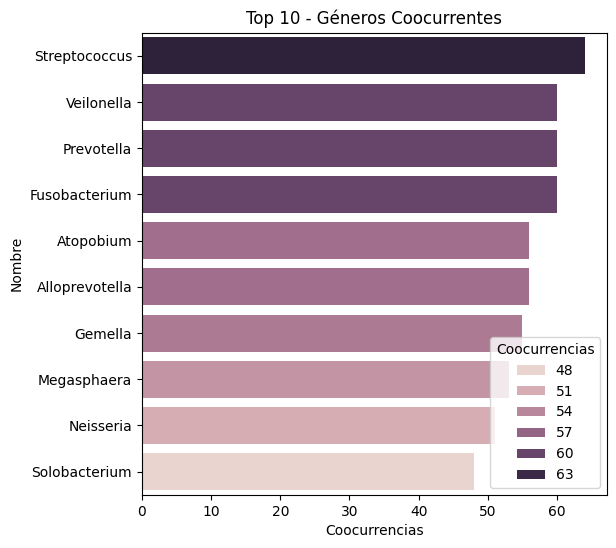

In [41]:
maximos = [(60,64,60,51,53,55,60,56,56,48)]
maximos = pd.DataFrame(maximos)
maximos = maximos.T
maximos.index = ['Veilonella','Streptococcus','Prevotella','Neisseria','Megasphaera','Gemella','Fusobacterium',
                 'Atopobium','Alloprevotella','Solobacterium']
maximos.columns = ['Coocurrencias']

# Sort the 'Coocurrencias' column in descending order
df_sorted = maximos.sort_values(by='Coocurrencias', ascending=False)

# Create the bar chart with quantity and color scale
plt.figure(figsize=(6, 6))
sns.barplot(x='Coocurrencias', y=df_sorted.index, hue=df_sorted['Coocurrencias'], data=df_sorted)

# Add labels and title
plt.xlabel('Coocurrencias')
plt.ylabel('Nombre')
plt.title('Top 10 - Géneros Coocurrentes')

# Set color palette
sns.set_palette('viridis')

# Show the plot
plt.show()

In [53]:
node_degrees = dict(net.degree())
# Ajustar el tamaño de los nodos según el número de conexiones
node_sizes = {node: degree * 1 for node, degree in node_degrees.items()}
node_sizes = dict(sorted(node_sizes.items(), key=lambda x: x[0]))
ordered_node_sizes = list(node_sizes.values())

In [55]:
node_sizes

{0: 29,
 2: 35,
 3: 8,
 4: 56,
 5: 56,
 7: 28,
 8: 21,
 9: 14,
 10: 19,
 11: 19,
 12: 41,
 13: 21,
 14: 40,
 16: 45,
 17: 11,
 19: 9,
 21: 9,
 22: 33,
 24: 20,
 25: 16,
 26: 22,
 27: 16,
 28: 28,
 29: 60,
 30: 55,
 31: 29,
 32: 37,
 33: 41,
 34: 14,
 35: 23,
 36: 14,
 37: 37,
 38: 42,
 40: 9,
 41: 53,
 42: 21,
 43: 16,
 44: 51,
 45: 20,
 46: 36,
 47: 38,
 48: 19,
 49: 22,
 50: 23,
 51: 47,
 52: 46,
 53: 60,
 54: 35,
 55: 30,
 56: 45,
 57: 9,
 58: 22,
 59: 43,
 60: 20,
 61: 48,
 63: 39,
 64: 64,
 65: 20,
 66: 25,
 67: 19,
 68: 32,
 69: 32,
 70: 60,
 71: 23,
 72: 25}

### Degree

In [23]:
degree = degree_75
node_colors_can_degree = list(degree.values())
node_colors_can_degree = np.array(node_colors_can_degree) / max(node_colors_can_degree)
pos_degree = nx.spring_layout(net, seed=2)

In [24]:
node_colors_can_degree

array([0.453125, 0.5     , 0.75    , 0.546875, 0.59375 , 0.359375,
       0.140625, 0.609375, 0.640625, 0.46875 , 0.25    , 0.296875,
       0.140625, 0.828125, 0.703125, 0.390625, 0.21875 , 0.328125,
       0.390625, 0.296875, 0.3125  , 0.34375 , 0.4375  , 0.296875,
       1.      , 0.671875, 0.140625, 0.734375, 0.515625, 0.21875 ,
       0.703125, 0.71875 , 0.359375, 0.796875, 0.171875, 0.4375  ,
       0.5     , 0.34375 , 0.3125  , 0.25    , 0.578125, 0.625   ,
       0.875   , 0.3125  , 0.328125, 0.65625 , 0.21875 , 0.453125,
       0.640625, 0.875   , 0.9375  , 0.359375, 0.578125, 0.859375,
       0.25    , 0.296875, 0.125   , 0.9375  , 0.5625  , 0.9375  ,
       0.34375 , 0.3125  , 0.140625, 0.328125, 0.546875])

### Eigenvector

In [25]:
eigenvector = eigenvector_can_75
node_colors_can_eigenvector = list(eigenvector.values())
node_colors_can_eigenvector = np.array(node_colors_can_eigenvector) / max(node_colors_can_eigenvector)
pos_eigenvector = nx.spring_layout(net, seed=2)

### Pagerank

In [26]:
pagerank = pagerank_can_75
node_colors_can_pagerank = list(pagerank.values())
node_colors_can_pagerank = np.array(node_colors_can_pagerank) / max(node_colors_can_pagerank)
pos_pagerank = nx.spring_layout(net, seed=2)

In [ ]:
# Para personalizar el tamaño y la posición de los nodos
#node_size = 100
#linewidth = 0.5
#font_family = "Arial"
#font_size = 8

### Closeness

In [27]:
closeness = closeness_can_75
node_colors_closeness = list(closeness.values())
node_colors_closeness = np.array(node_colors_closeness) / max(node_colors_closeness)
pos_closeness = nx.spring_layout(net, seed=2)

### Betweenness

In [29]:
betweenness = betweenness_can_75
node_colors_betweenness = list(betweenness.values())
node_colors_betweenness = np.array(node_colors_betweenness) / max(node_colors_betweenness)
pos_betweenness = nx.spring_layout(net, seed=2)

### Current Flow Closeness

In [30]:
current_flow_closenness = current_flow_closenness_can_75
node_colors_current_flow_closenness = list(current_flow_closenness.values())
node_colors_current_flow_closenness = np.array(node_colors_current_flow_closenness) / max(node_colors_current_flow_closenness)
pos_current_flow_closenness = nx.spring_layout(net, seed=2)

### Current Flow Betweenness

In [31]:
current_flow_betweenness = current_flow_betweenness_can_75
node_colors_current_flow_betweenness = list(current_flow_betweenness.values())
node_colors_current_flow_betweenness = np.array(node_colors_current_flow_betweenness) / max(node_colors_current_flow_betweenness)
pos_current_flow_betweenness = nx.spring_layout(net, seed=2)

In [32]:
node_colors_current_flow_betweenness

array([0.26896831, 0.33577481, 0.58149702, 0.52877312, 0.42315987,
       0.21300325, 0.16983796, 0.43231291, 0.46683157, 0.34588526,
       0.17265998, 0.19536181, 0.16983796, 0.62140868, 0.49526731,
       0.22570369, 0.16140938, 0.24429692, 0.29977022, 0.18859349,
       0.20515371, 0.2083164 , 0.30493311, 0.19536181, 1.        ,
       0.48751779, 0.16983796, 0.5584984 , 0.40940725, 0.16140938,
       0.68657146, 0.54988837, 0.21300325, 0.61682937, 0.11918724,
       0.30493311, 0.34671007, 0.2083164 , 0.20515371, 0.17265998,
       0.5986403 , 0.5915792 , 0.69168942, 0.20515371, 0.25935505,
       0.49519168, 0.16140938, 0.26896831, 0.46248055, 0.69087223,
       0.78471899, 0.20910406, 0.45112221, 0.68926197, 0.17265998,
       0.18859349, 0.07551   , 0.78471899, 0.41174478, 0.90168206,
       0.2083164 , 0.20515371, 0.16983796, 0.212951  , 0.33856619])

### Communicability

In [33]:
communicability = communicability_can_75
node_colors_communicability = list(communicability.values())
node_colors_communicability = np.array(node_colors_communicability) / max(node_colors_communicability)
pos_communicability = nx.spring_layout(net, seed=2)

In [34]:
node_colors_communicability

array([0.52755161, 0.56978266, 0.83474435, 0.59437487, 0.67340584,
       0.38202694, 0.03900867, 0.70783963, 0.72963851, 0.49683001,
       0.18700577, 0.25125024, 0.03900867, 0.91933611, 0.81598386,
       0.44256403, 0.14149196, 0.30297991, 0.36036692, 0.27101023,
       0.26898149, 0.35995983, 0.44025027, 0.25125024, 1.        ,
       0.77829391, 0.03900867, 0.82539635, 0.52320578, 0.14149196,
       0.76378383, 0.81054093, 0.38202694, 0.88713096, 0.09869656,
       0.44025027, 0.55715975, 0.35995983, 0.26898149, 0.18700577,
       0.61629904, 0.70443546, 0.94491946, 0.26898149, 0.2796982 ,
       0.74819163, 0.14149196, 0.52755161, 0.73213729, 0.94553633,
       0.97904888, 0.38898828, 0.62130461, 0.93311212, 0.18700577,
       0.27101023, 0.05977269, 0.97904888, 0.6311347 , 0.97093519,
       0.35995983, 0.26898149, 0.03900867, 0.3180676 , 0.65477255])

### Harmonic

In [35]:
harmonic = harmonic_can_75
node_colors_harmonic = list(harmonic.values())
node_colors_harmonic = np.array(node_colors_harmonic) / max(node_colors_harmonic)
pos_harmonic = nx.spring_layout(net, seed=2)


In [36]:
len(pos_harmonic)

65

Para graficar de a un grafico:

In [37]:
node_colors_harmonic

array([0.7265625, 0.7734375, 0.5625   , 0.9375   , 0.9375   , 0.71875  ,
       0.6640625, 0.609375 , 0.6484375, 0.6484375, 0.8203125, 0.6640625,
       0.8125   , 0.8515625, 0.5859375, 0.5703125, 0.5703125, 0.7578125,
       0.65625  , 0.625    , 0.671875 , 0.625    , 0.71875  , 0.96875  ,
       0.9296875, 0.7265625, 0.7890625, 0.8203125, 0.609375 , 0.6796875,
       0.609375 , 0.7890625, 0.828125 , 0.5703125, 0.9140625, 0.6640625,
       0.625    , 0.8984375, 0.65625  , 0.78125  , 0.796875 , 0.6484375,
       0.671875 , 0.6796875, 0.8671875, 0.859375 , 0.96875  , 0.7734375,
       0.734375 , 0.8515625, 0.5703125, 0.671875 , 0.8359375, 0.65625  ,
       0.875    , 0.8046875, 1.       , 0.65625  , 0.6953125, 0.6484375,
       0.75     , 0.75     , 0.96875  , 0.6796875, 0.6953125])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


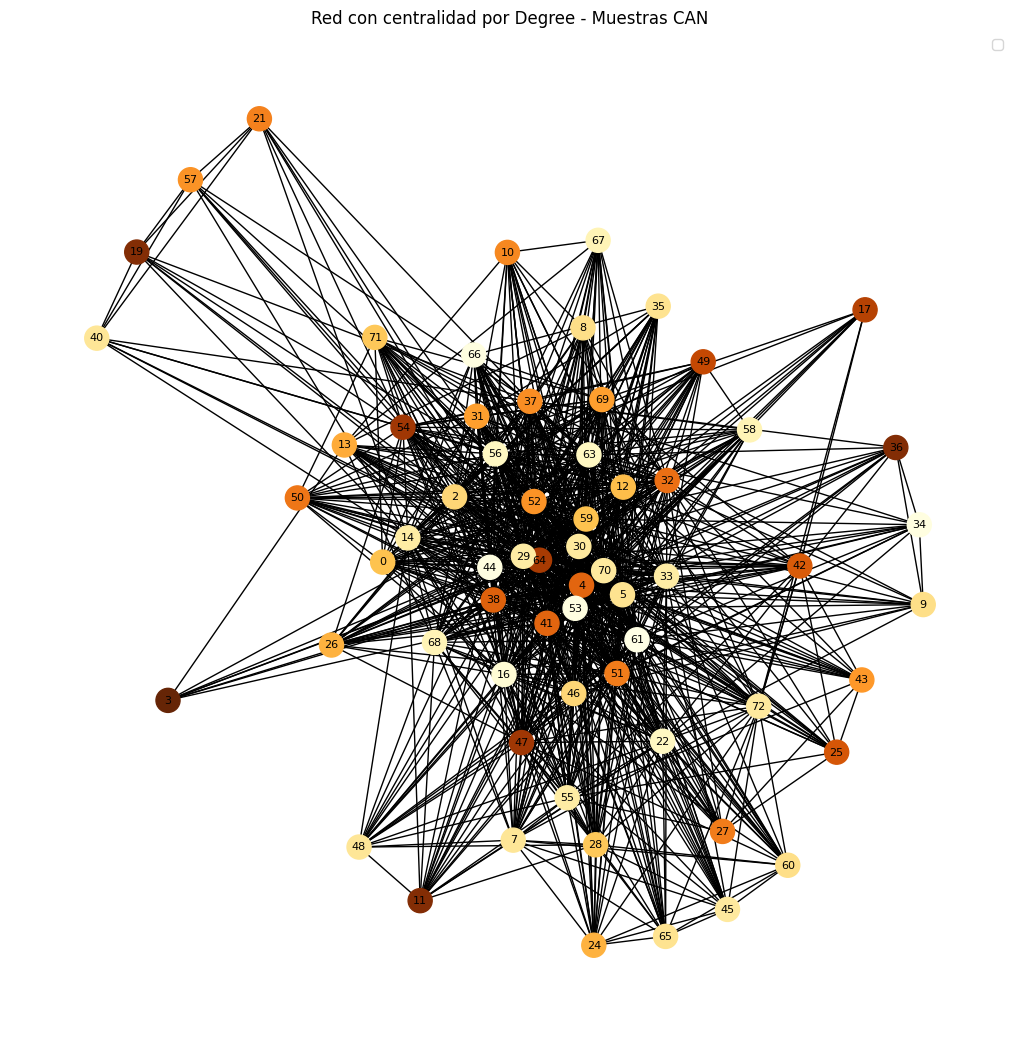

In [38]:
# Visualizar la red con colores por centralidad de PageRank
plt.figure(figsize=(10,10))
nx.draw(net, with_labels = True, cmap = plt.cm.YlOrBr, pos=pos_harmonic, node_color= node_colors_harmonic, font_size = 8)
# Agregar título y etiquetas
plt.title("Red con centralidad por Degree - Muestras CAN")
plt.legend(loc="best")
plt.show()

Función para generar gráficos

In [49]:

def ver_redes (net,c_degree, c_eigenvector, c_pagerank, c_betweenness, c_closeness, c_current_flow_betweenness, c_current_flow_closeness, c_communicability, c_harmonic,
                pos_degree, pos_eigenvector, pos_pagerank, pos_betweenness, pos_closeness, pos_current_flow_betweenness, pos_current_flow_closeness, pos_communicability, pos_harmonic):
    fig, axs = plt.subplots(5, 2, figsize=(20, 30))
    # Gráfico de degree
    nx.draw(net, with_labels=True, node_color=c_degree, cmap=plt.cm.Wistia, pos=pos_degree, ax=axs[0,0])
    axs[0,0].set_title("Degree Centrality")

    # Gráfico de eigenvector
    nx.draw(net, with_labels=True, node_color=c_eigenvector, cmap=plt.cm.Wistia, pos=pos_eigenvector, ax=axs[1,0])
    axs[1,0].set_title("Eigenvector Centrality")

    # Gráfico de pagerank
    nx.draw(net, with_labels=True, node_color=c_pagerank, cmap=plt.cm.Wistia, pos=pos_pagerank, ax=axs[2,0])
    axs[2,0].set_title("Pagerank Centrality")

    # Gráfico de betweenness
    nx.draw(net, with_labels=True, node_color=c_betweenness, cmap=plt.cm.Wistia, pos=pos_betweenness, ax=axs[3,0])
    axs[3,0].set_title("Betweenness Centrality")

    # Gráfico de closenness
    nx.draw(net, with_labels=True, node_color=c_closeness, cmap=plt.cm.Wistia, pos=pos_closeness, ax=axs[0,1])
    axs[0,1].set_title("Closenness Centrality")

    # Gráfico de current flow betweenness
    nx.draw(net, with_labels=True, node_color=c_current_flow_betweenness, cmap=plt.cm.Wistia, pos=pos_current_flow_betweenness, ax=axs[1,1])
    axs[1,1].set_title("Current Flow Betweenness Centrality")

    # Gráfico de current flow closenness
    nx.draw(net, with_labels=True, node_color=c_current_flow_closeness, cmap=plt.cm.Wistia, pos=pos_current_flow_closenness, ax=axs[2,1])
    axs[2,1].set_title("Current Flow Closenness Centrality")

    # Gráfico de Communicability
    nx.draw(net, with_labels=True, node_color=c_communicability, cmap=plt.cm.Wistia, pos=pos_communicability, ax=axs[3,1])
    axs[3,1].set_title("Communicability Centrality")

    # Gráfico de Harmonic
    nx.draw(net, with_labels=True, node_color=c_harmonic, cmap=plt.cm.Wistia, pos=pos_harmonic, ax=axs[4,0])
    axs[4,0].set_title("Harmonic Centrality")


    sns.barplot(x='Coocurrencias', y=df_sorted.index, hue=df_sorted['Coocurrencias'],
                palette= plt.cm.Wistia , data=df_sorted, ax=axs[4,1])
    # Add labels and title
    plt.xlabel('Coocurrencias')
    plt.ylabel('')
    plt.title('Top 10 Géneros Coocurrentes - Red CAN')

    # Ajustar el espacio entre subplots
    plt.subplots_adjust(wspace=0.1)

    # Mostrar la figura
    plt.show()


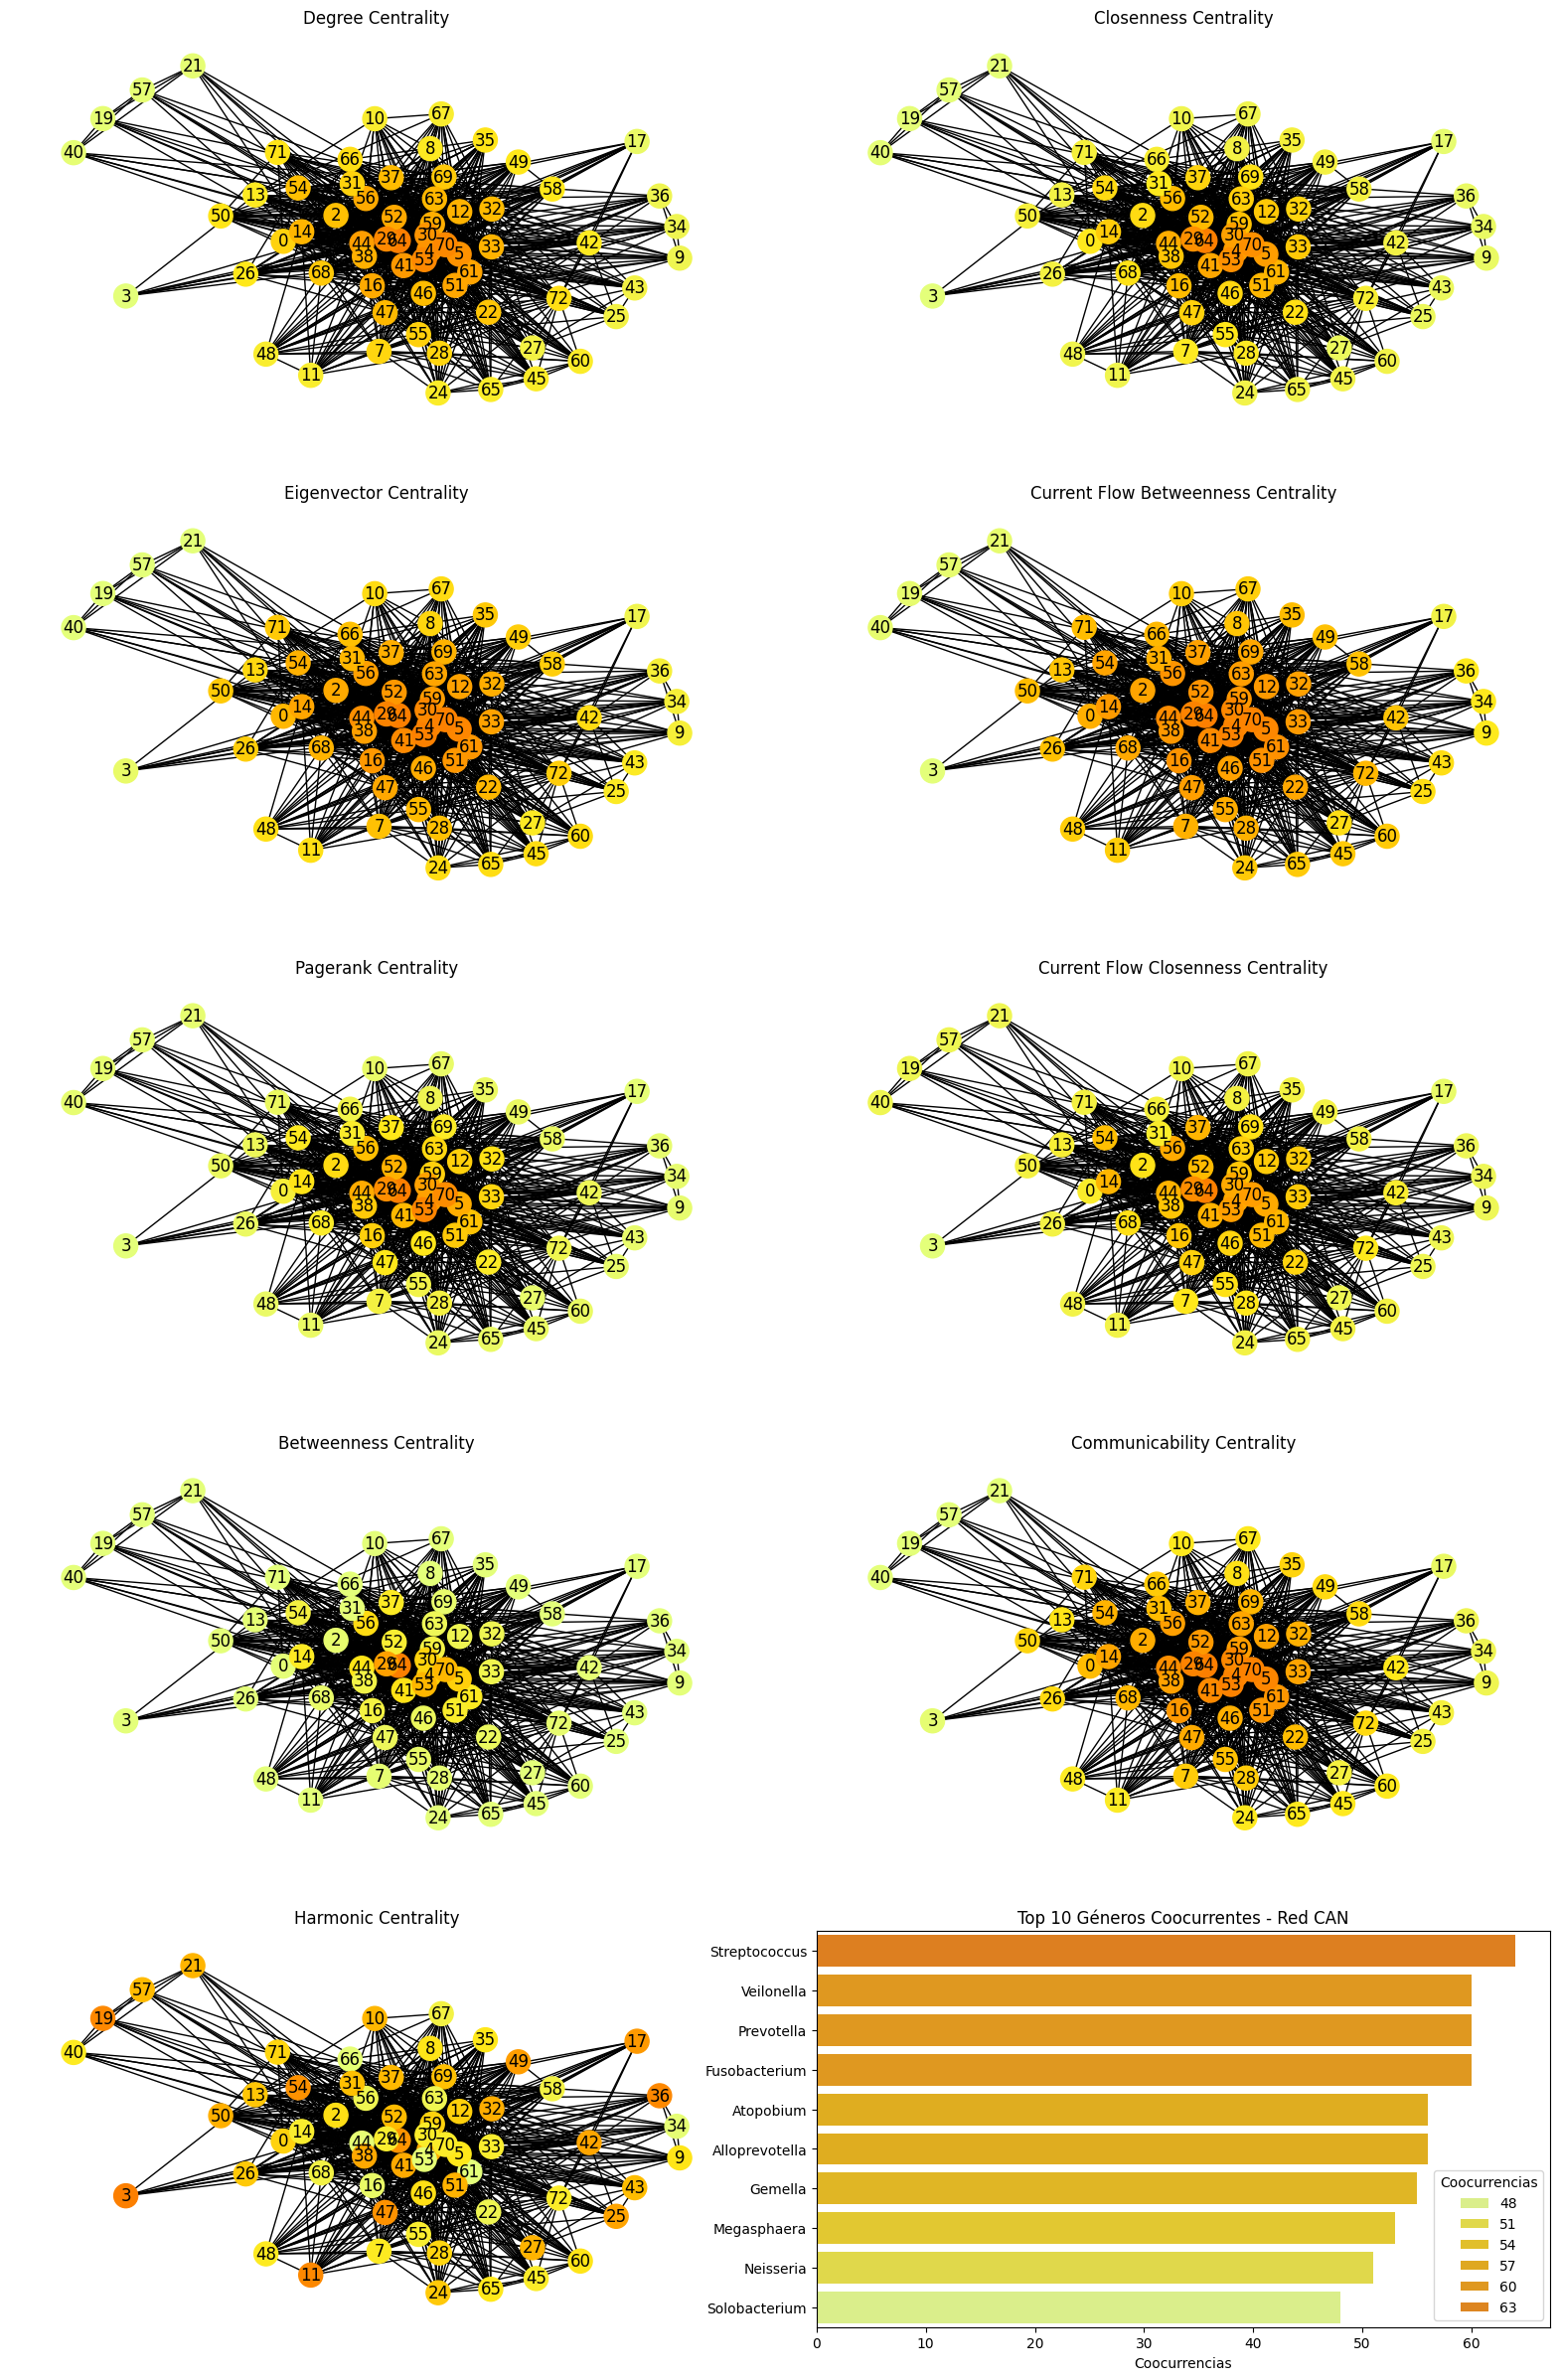

In [50]:
ver_redes(net, node_colors_can_degree, node_colors_can_eigenvector, node_colors_can_pagerank, node_colors_betweenness, node_colors_closeness, node_colors_current_flow_closenness, node_colors_current_flow_betweenness, node_colors_communicability, node_colors_harmonic,
          pos_degree, pos_eigenvector, pos_pagerank, pos_betweenness,pos_closeness, pos_current_flow_closenness, pos_current_flow_betweenness, pos_communicability, pos_harmonic)